# Clustering different neighborhoods along BART network in SF Bay area

<img src="files/BART_map.png">

Figure Source: https://www.bart.gov/system-map

#  Introduction/Business Problem

In this project we will explore the neighborhoods around different BART stations in San Francisco Bay area. When someone starts working in the bay area and migrates from a different a different location, one of the key considerations is to find an accomodation that meets different preferences of the individual. These preferences can be: (1) Distance from the work place, (2) Accessibility of different resturants and/or grocery stores, (3) Accessibility to schools, (4) Cost of living, (5) Night life, among others. Given the indivual wants to rely on BART for transportation, there can be tradeoff among different attributes in the neighborhoods around the BART stations. As an example, the neighborhoods around BART stations in SF downtown can be pretty good with respect to accessibility to resturants, night life, however, the cost of living can be pertty high. Hence, the goal of this project is to cluster different BART stations on the basis of: (a) different venues in their neighborhoods and (b) proximity to the work place of the individual (one who is looking for accomodation) such that that BART stations that share the common attributes fall in the same cluster. This framework for can be helpful to decide an appropriate location for accomodation as one can form clusters with respect to the preferences that can be easily quantifiable, and then within the elements of desirable cluster a subjective decision can be made to find an accomodation based on unquantifiable personal preferences.

# Data

To address the above problem, the data is collected from two sources, wikipedia and foursquare. 

Web scraping is performed on the wikipedia to get the names of different stations that are served by BART, and then the latitudes and longitudes of different BART stations are obtained using the Nominatim package from geopy.geocoders.

After obtaining the latitudes and longitudes of different BART stations, the number of differet venues around 1 mile radius of the BART stations are obtained using the foursquare database. The types of venus that an individual wants to explore can be a personal preference, but for the purpose of this study, the following set of venues are explored:
(1) Arts and Entertainment venues, 
(2) Food and Resturants, 
(3) Nightlife spots, 
(4) Outdoor and Recreation sports, 
(5) Professional locations like autitoriums, business centers, Government buildings, etc.

Along with the number of different types of venues, the distance of the BART station from a base location like at invidual's work place is also considered as an attribute for clustering. Though a much wider variety of attributes can be considered for this exercise, in order to avoid exceeding the limit of number of foursquare queries per day only a maximum of 25 BART stations and the above described venues are considered.

In [1]:
# Importing all the required packages
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.exc import GeocoderTimedOut
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
import re
import geopy.distance
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import time
print('Libraries imported.')

Libraries imported.


In [3]:
'''Importing a base location (example: work location of the individual) to calculate the distance of 
different BART Stations'''

myLocation='One Maritime Plaza, San Francisco'
geolocator = Nominatim(user_agent="bart_explorer",timeout=50)
location = geolocator.geocode(myLocation)
myLatitude=location.latitude
myLongitude=location.longitude

## Web scraping to obtain data from Wikipedia 

In [2]:
# Scraping the list of Bart stations from wikipedia
BartStations=pd.read_html('https://en.wikipedia.org/wiki/List_of_Bay_Area_Rapid_Transit_stations')
BartStations=pd.DataFrame(BartStations[2]['Station'])
BartStations.head()

,Station
0,12th Street Oakland City Center^
1,16th Street Mission
2,19th Street Oakland^
3,24th Street Mission
4,Antioch[a]


## Data cleaning

In [4]:
'''Cleaning the BART name data obtained from wikipedia in order to obtain the latitudes and longitudes of 
different BART stations. In order to avoid geolocator timeout, and avoid maxing out the number of queries to the
Foursquare database, only at max 25 BART stations are considered in this analysis.
'''

Bart_data=pd.DataFrame(columns=['Station', 'Latitude','Longitude','Distance'])
for station in BartStations['Station'][:25]:
    ind=re.search(r"[\^\[\(]", station) 
    if not(ind==None): station=station[:ind.span()[0]]
    if station in ['Balboa Park', 'Fruitvale']:    # Skipping the Bolbla park and Fruitvale because geolocator is not getting correct coordinates for these stations
        continue
    address=station+', North California'
    print(address)
    geolocator = Nominatim(user_agent="bart_explorer1")
    
    time.sleep(2)
    location = geolocator.geocode(address)

    
    dist=geopy.distance.vincenty((myLatitude,myLongitude),(location.latitude,location.longitude)).miles
    Bart_data=Bart_data.append({'Station':station,
                     'Latitude':location.latitude,
                     'Longitude':location.longitude,
                    'Distance':dist},ignore_index=True)

12th Street Oakland City Center, North California


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


16th Street Mission, North California
19th Street Oakland, North California
24th Street Mission, North California
Antioch, North California
Ashby, North California
Bay Fair, North California
Downtown Berkeley, North California
Castro Valley, North California
Civic Center / UN Plaza , North California
Coliseum , North California
Colma, North California
Concord, North California
Daly City, North California
Dublin / Pleasanton, North California
El Cerrito del Norte, North California
El Cerrito Plaza, North California
Embarcadero , North California
Fremont, North California
Glen Park , North California
Hayward, North California
Lafayette, North California
Lake Merritt, North California


In [37]:
Bart_data.head()

,Station,Latitude,Longitude,Distance
0,12th Street Oakland City Center,37.803496,-122.271692,7.002043
1,16th Street Mission,37.765069,-122.419678,2.389434
2,19th Street Oakland,37.806816,-122.269556,7.139418
3,24th Street Mission,37.752256,-122.418449,3.174459
4,Antioch,38.004921,-121.805789,35.498810


In [36]:
Bart_data.shape

(23, 4)

The Bart_data data frame has the latitude, longitues and distance from the work place data corresponding to 23 BART stations.

## Visualizing the BART stations on an interactive map

Here we are visualizing the 23 BART stations that are being considered for the clustering exercise on an interactive map using the Python's Folium package. Though we are working with a subset of all the BART stations, tt can be seen that the BART staions being considered are well distributed over the regions that are servided by BART. In this remainder of this notebook we will cluster similar BART stations based on the datasets that were discussed in the Data section of this report

In [6]:
# create map of the bart statiosn using latitude and longitude values
map_sf = folium.Map(location=[myLatitude, myLongitude+0.2], zoom_start=10)
for station,lat, lng in zip(Bart_data['Station'],Bart_data['Latitude'],Bart_data['Longitude']):
    label=folium.Popup(station,parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_sf)
     
map_sf

# Methodology

This section describes the methodology used for clustering. For each considered BART station, its latitude and longitude are used to obtain the number of different venues within 1 mile radius (as discussed the Data section of the report) from the Foursquare database. Then the venue data is merged with the BART data to obtain one merged dataset, MergedDataset, that containes the locations of all the bart stations, their distance from the work place of the individual, and the number of different types of venues. From this merged dataset the set of features as described the Data section are extracted and normalized using standard normal scalar to perform clustering using the K-means algorithm with number of clusters equal to 5.

### Accessing the Foursquare dataset to obtain different venues in proximity to different BART stations.

In [99]:
# Foursquare credentials to access their dataset
CLIENT_ID = 'YT0EDB1LIXWATJQOLVZ1PSQMSN1PNAGZGZCP5SCSMYRWHMIR' # your Foursquare ID
CLIENT_SECRET = 'ZIVSV1Q1ZNU2MC1TAHBLKAXBOPATECKAUZCFVJG3F3UGZBJM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [8]:
''' Identifying relavent venue categories from https://developer.foursquare.com/docs/resources/categories.
Working with a reduced set of venues so that I do not exceed the query limit for foursquare. For a more elaborate
analysis, the upper list can be used.
'''

#VenueCat={'Entertainment':'4d4b7104d754a06370d81259',
#         'College':'4d4b7105d754a06372d81259',
#         'Food':'4d4b7105d754a06374d81259',
#         'VegFood':'4bf58dd8d48988d1d3941735',
#          'NightLife':'4d4b7105d754a06376d81259',
#          'OutdoorAct':'4d4b7105d754a06377d81259',
#          'ProfessSpaces':'4d4b7105d754a06375d81259',
#          'Residence':'4e67e38e036454776db1fb3a',
#          'FoodStores':'4bf58dd8d48988d1f9941735'
#         }

VenueCat={'Entertainment':'4d4b7104d754a06370d81259',
         'Food':'4d4b7105d754a06374d81259',
          'NightLife':'4d4b7105d754a06376d81259',
          'OutdoorAct':'4d4b7105d754a06377d81259',
          'ProfessSpaces':'4d4b7105d754a06375d81259',
         }

In [9]:
# Function to get the number of venues within a given radius(default 1 mile) of a BART station.
def getNearbyVenues(names, latitudes, longitudes, cat=VenueCat,radius=1609,LIMIT=100):
    nearby_venues = pd.DataFrame(columns=[key for key in VenueCat])
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        for key in cat:
            #print(key)
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            cat[key])
            
            # make the GET request
            results = requests.get(url).json()
            nearby_venues.loc[name,key]=results['response']['totalResults']
    return(nearby_venues)

In [10]:
# Accessing the number of venues in different categories around different bart stations
Nearby_venues=getNearbyVenues(Bart_data.loc[:,'Station'],Bart_data.loc[:,'Latitude'],Bart_data.loc[:,'Longitude'],VenueCat)
Nearby_venues.reset_index(drop=False,inplace=True)
Nearby_venues.rename(columns={'index':'Station'},inplace=True)
Nearby_venues.head()

,Station,Entertainment,Food,NightLife,OutdoorAct,ProfessSpaces
0,12th Street Oakland City Center,74.0,174.0,79.0,116.0,182.0
1,16th Street Mission,130.0,248.0,184.0,165.0,190.0
2,19th Street Oakland,71.0,193.0,78.0,116.0,190.0
3,24th Street Mission,90.0,246.0,98.0,134.0,170.0
4,Antioch,6.0,32.0,13.0,8.0,66.0


In [23]:
# Merging 'Bart_data' with the 'Nearby_venues' data
MergedDataset=pd.merge(Nearby_venues,Bart_data,left_on='Station',right_on='Station')
MergedDataset.head()

,Station,Entertainment,Food,NightLife,OutdoorAct,ProfessSpaces,Latitude,Longitude,Distance
0,12th Street Oakland City Center,74.0,174.0,79.0,116.0,182.0,37.803496,-122.271692,7.002043
1,16th Street Mission,130.0,248.0,184.0,165.0,190.0,37.765069,-122.419678,2.389434
2,19th Street Oakland,71.0,193.0,78.0,116.0,190.0,37.806816,-122.269556,7.139418
3,24th Street Mission,90.0,246.0,98.0,134.0,170.0,37.752256,-122.418449,3.174459
4,Antioch,6.0,32.0,13.0,8.0,66.0,38.004921,-121.805789,35.498810


### Obtaining the relevant features and scaling the data to feed into a the K-means clusetering algorithm

In [24]:
'''Preperating feature set to feed into a clustering algorithm. Choosing relevant features and scaling them
according to standard normal dist.'''

X=MergedDataset.drop(['Station','Latitude','Longitude'],axis=1)
X=preprocessing.StandardScaler().fit(X).transform(X)

### Clustering different Bart stations using K-means

In [25]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)


# adding cluster labels
Bart_clusters=pd.DataFrame(MergedDataset['Station'])
Bart_clusters.insert(0,'Cluster Labels',kmeans.labels_)
MergedDataset=pd.merge(MergedDataset,Bart_clusters,on='Station')

### Sorted list of BART stations in different clusters

In [28]:
MergedDataset.sort_values('Cluster Labels',inplace=True)
MergedDataset.reset_index(drop=True, inplace=True)
MergedDataset.head(25)

,Station,Entertainment,Food,NightLife,OutdoorAct,ProfessSpaces,Latitude,Longitude,Distance,Cluster Labels
0,12th Street Oakland City Center,74.0,174.0,79.0,116.0,182.0,37.803496,-122.271692,7.002043,0
1,24th Street Mission,90.0,246.0,98.0,134.0,170.0,37.752256,-122.418449,3.174459,0
2,Lake Merritt,56.0,182.0,82.0,121.0,179.0,37.796824,-122.264190,7.392602,0
3,19th Street Oakland,71.0,193.0,78.0,116.0,190.0,37.806816,-122.269556,7.139418,0
4,Hayward,9.0,86.0,12.0,26.0,84.0,37.668821,-122.080796,19.515347,1
5,Bay Fair,6.0,96.0,9.0,17.0,85.0,37.697049,-122.126475,16.415116,1
6,Castro Valley,4.0,91.0,8.0,21.0,127.0,37.694552,-122.085743,18.532704,1
7,Coliseum,10.0,45.0,4.0,21.0,95.0,37.753970,-122.197205,11.429434,1
8,Lafayette,6.0,46.0,4.0,20.0,127.0,37.885758,-122.118020,16.589287,1
9,El Cerrito del Norte,9.0,52.0,6.0,23.0,68.0,37.924354,-122.316284,9.966372,1


# Results

In this section we visualize the clusters obtained from the k-means algorithms by: (1) plotting them on an interactive map using Python's folium package, and (2) generating boxplots that help us to visualize the different attributes of the BART stations that fall in different clusters. The interpretation of these clusters is presented in the following section. 

### Visualizing the clusters on an interactive map

In [29]:
# create map
map_clusters = folium.Map(location=[myLatitude, myLongitude+0.2], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MergedDataset['Latitude'], MergedDataset['Longitude'], MergedDataset['Station'], MergedDataset['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

### Visualizing the attributes of different clusters

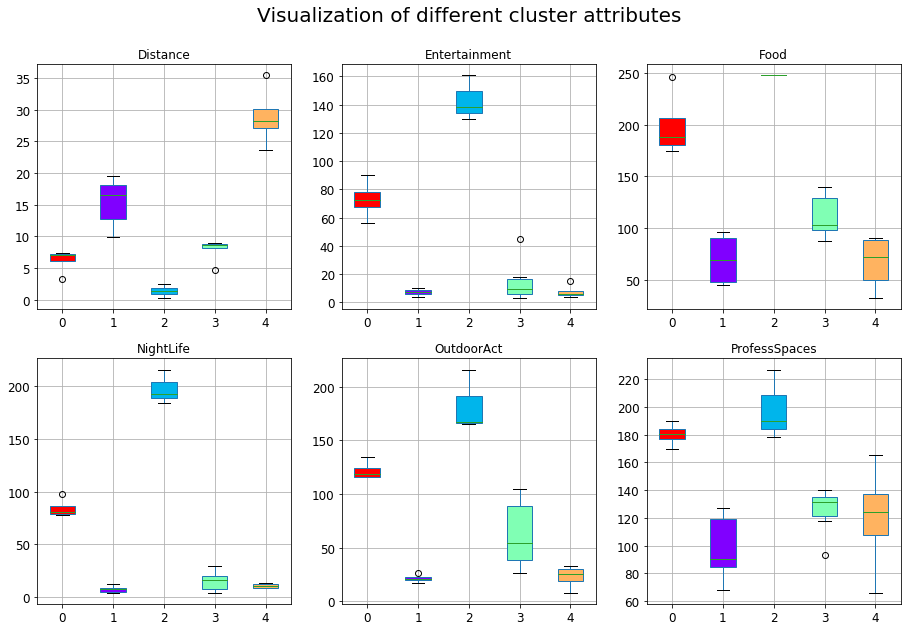

In [33]:
# Visualizing the attributes of different clusters
plt.rcParams['figure.figsize'] = [15, 10]
boxprops = dict(linestyle='-', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='k')
fig, ax_new = plt.subplots(2,3, sharey=False)
bp=MergedDataset[['Cluster Labels','Entertainment','Food','NightLife','OutdoorAct','ProfessSpaces','Distance']].boxplot(by='Cluster Labels',return_type='both',
    patch_artist = True,layout=(2,3),ax=ax_new,fontsize=12)
colors = rainbow
for row_key, (ax,row) in bp.iteritems():
    ax.set_xlabel('',fontsize=13)
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i-1])
#bp['Entertainment'].ax.set_ylim(0,175)
#bp['Distance'].ax.set_ylim(0,40)
fig.suptitle('Visualization of different cluster attributes',fontsize=20)
plt.show()
#

# Discussion

In this sections an interpretation of different clusters is offered, and it is discussed how these clusters can help in the decision making process of the individual looking for an appropriate location of accomodation. First the attention is foucused on the clusters the stand out, namely cluseters 2 and 4.

In [96]:
def filterfun(df,clusterlabels):
    ind=pd.Series(np.zeros((23,),dtype=bool))
    for cluster in clusterlabels:
        indi=MergedDataset['Cluster Labels']==cluster
        ind=np.logical_or(ind,indi)
    return ind

In [97]:
MergedDataset[filterfun(MergedDataset,[2,4])]

,Station,Entertainment,Food,NightLife,OutdoorAct,ProfessSpaces,Latitude,Longitude,Distance,Cluster Labels
10,16th Street Mission,130.0,248.0,184.0,165.0,190.0,37.765069,-122.419678,2.389434,2
11,Embarcadero,138.0,248.0,193.0,216.0,227.0,37.792864,-122.396912,0.233705,2
12,Civic Center / UN Plaza,161.0,248.0,216.0,167.0,178.0,37.779362,-122.413972,1.384355,2
19,Fremont,15.0,56.0,8.0,22.0,165.0,37.548270,-121.988572,28.249466,4
20,Antioch,6.0,32.0,13.0,8.0,66.0,38.004921,-121.805789,35.498810,4
21,Dublin / Pleasanton,6.0,88.0,12.0,33.0,121.0,37.701580,-121.898038,28.205226,4
22,Concord,4.0,90.0,8.0,29.0,128.0,37.976852,-122.033562,23.573047,4


Cluster 2 comprises the BART statios that are in close proximity to the work location, and have significant higher number of venues (all types), in comparison to the venues in Cluster 4. Hence with respect to the attributes considered in this analysis the Cluster 2 seems to have completely dominated the cluster 4. However, there can be a potential tradeoff when other attributes like cost of living, safety index are brounght in the analysis. Next the attributes of the remaining clusters are investigated.

In [98]:
MergedDataset[filterfun(MergedDataset,[0,1,3])]

,Station,Entertainment,Food,NightLife,OutdoorAct,ProfessSpaces,Latitude,Longitude,Distance,Cluster Labels
0,12th Street Oakland City Center,74.0,174.0,79.0,116.0,182.0,37.803496,-122.271692,7.002043,0
1,24th Street Mission,90.0,246.0,98.0,134.0,170.0,37.752256,-122.418449,3.174459,0
2,Lake Merritt,56.0,182.0,82.0,121.0,179.0,37.796824,-122.264190,7.392602,0
3,19th Street Oakland,71.0,193.0,78.0,116.0,190.0,37.806816,-122.269556,7.139418,0
4,Hayward,9.0,86.0,12.0,26.0,84.0,37.668821,-122.080796,19.515347,1
5,Bay Fair,6.0,96.0,9.0,17.0,85.0,37.697049,-122.126475,16.415116,1
6,Castro Valley,4.0,91.0,8.0,21.0,127.0,37.694552,-122.085743,18.532704,1
7,Coliseum,10.0,45.0,4.0,21.0,95.0,37.753970,-122.197205,11.429434,1
8,Lafayette,6.0,46.0,4.0,20.0,127.0,37.885758,-122.118020,16.589287,1
9,El Cerrito del Norte,9.0,52.0,6.0,23.0,68.0,37.924354,-122.316284,9.966372,1


After cluster 2, it can be seen that Cluster 0 has the least distance from the work place and also stands out in comparison to clusters 1, 3, and 5 with respect to number of different venues around the BART stations. These locations can be interest to someone who want to stay at a relatively economical place than the places in Cluster 0. Note that the comment on the relative cost of living at different places are made per the experience of the author and are not based on the analysis pesented herein.

Comparing the BART stations in Clusters 1 and 3, from the Box plot it can be seen that the sations in Cluster 1 are relatively far away than the stations in Cluster 3. With respect to night life, both these groups are not significantly different but cluster 3 definitely has more to offer in terms of Food places and Outdoor activities.

Hence, as discussed above, by analyzing the data as done in this project, one can explore different neighborhoods, evaluate pros and cons of staying at different locations, and then choose an appropriate location to stay.

# Conclusions

In this project, the neighborhoods around different BART stations in the Bay area are analyzed and different BART statiosn are clustered based on the shared attributed of the neighborhoods. It was seen that K-means was successful in analyzing the data and identifying meaning relationships in different groups that can aid in the process of identifying neighborhood that meets the accomodation preferences an indivual. It should be noted that the analysis presented here is not exhaustive becuase a very limited set of attributes for each BART station's neighborhood have been considered, however, insights are offered based on the observations made from the presented analysis. Future steps can be: (1) to include the complete set of BART stations, (2) include other relevant attributes from the Foursquare dataset, (3) include attributes like the renting cost, safety index, etc., to have a rather robust BART neighborhood segementaion framework that captures all the potentially relavant attributes.